In [1]:
from TCT import name_resolver
from TCT import node_normalizer
from TCT import translator_metakg
from TCT import translator_kpinfo
from TCT import TCT

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import pandas as pd
import  seaborn as sns
import networkx as nx
import numpy as np
import ipycytoscape
import yaml

In [2]:
# Preparation 
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= translator_kpinfo.get_translator_kp_info()
print(len(Translator_KP_info))
# Step 2: Get metaKG and all predicates from Translator APIs through the SmartAPI system
metaKG = translator_metakg.get_KP_metadata(APInames) 
print(metaKG.shape)
# Add metaKG from Plover API based KG resources
APInames,metaKG = translator_metakg.add_plover_API(APInames, metaKG)
print(metaKG.shape)
# Step 3: list metaKG information
All_predicates = list(set(metaKG['Predicate']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
API_withMetaKG = list(set(metaKG['API']))
print(len(API_withMetaKG))
print(len(All_predicates))
print(len(All_categories))

# ARA list
API_withMetaKG = set(metaKG['API'])
print("ARA list:", set(APInames.keys()) - API_withMetaKG)

53
(10580, 5)
(22129, 5)
42
184
108
ARA list: {'OpenPredict API', 'Answer-coalesce(Trapi v1.5.0)', 'Sri-answer-appraiser(Trapi v1.5.0)', 'ARAX Translator Reasoner - TRAPI 1.5.0', 'Autonomous Relay System (ARS) TRAPI', 'Aragorn(Trapi v1.5.0)', 'mediKanren', 'Cqs(Trapi v1.5.0)', 'Sri-node-normalizer(Trapi v1.5.0)', 'Workflow-runner(Trapi v1.5.0)'}


In [3]:

# find the KG in one individual API (optional)
metaKG.loc[metaKG['API'] == 'CATRAX BigGIM DrugResponse Performance Phase KP - TRAPI 1.5.0',['API','Predicate','Subject','Object']].drop_duplicates()

,API,Predicate,Subject,Object
10580,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:expressed_in,biolink:Gene,biolink:Cell
10581,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:physically_interacts_with,biolink:Gene,biolink:Gene
10582,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:gene_associated_with_condition,biolink:Gene,biolink:Disease
10583,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:associated_with_sensitivity_to,biolink:Gene,biolink:SmallMolecule
10584,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:associated_with_resistance_to,biolink:Gene,biolink:SmallMolecule
10585,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:associated_with_resistance_to,biolink:Gene,biolink:MolecularMixture
10586,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:associated_with_sensitivity_to,biolink:Gene,biolink:MolecularMixture
10587,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:biomarker_for,biolink:Gene,biolink:Disease
10588,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:physically_interacts_with,biolink:SmallMolecule,biolink:Gene
10589,CATRAX BigGIM DrugResponse Performance Phase K...,biolink:physically_interacts_with,biolink:MolecularMixture,biolink:Gene


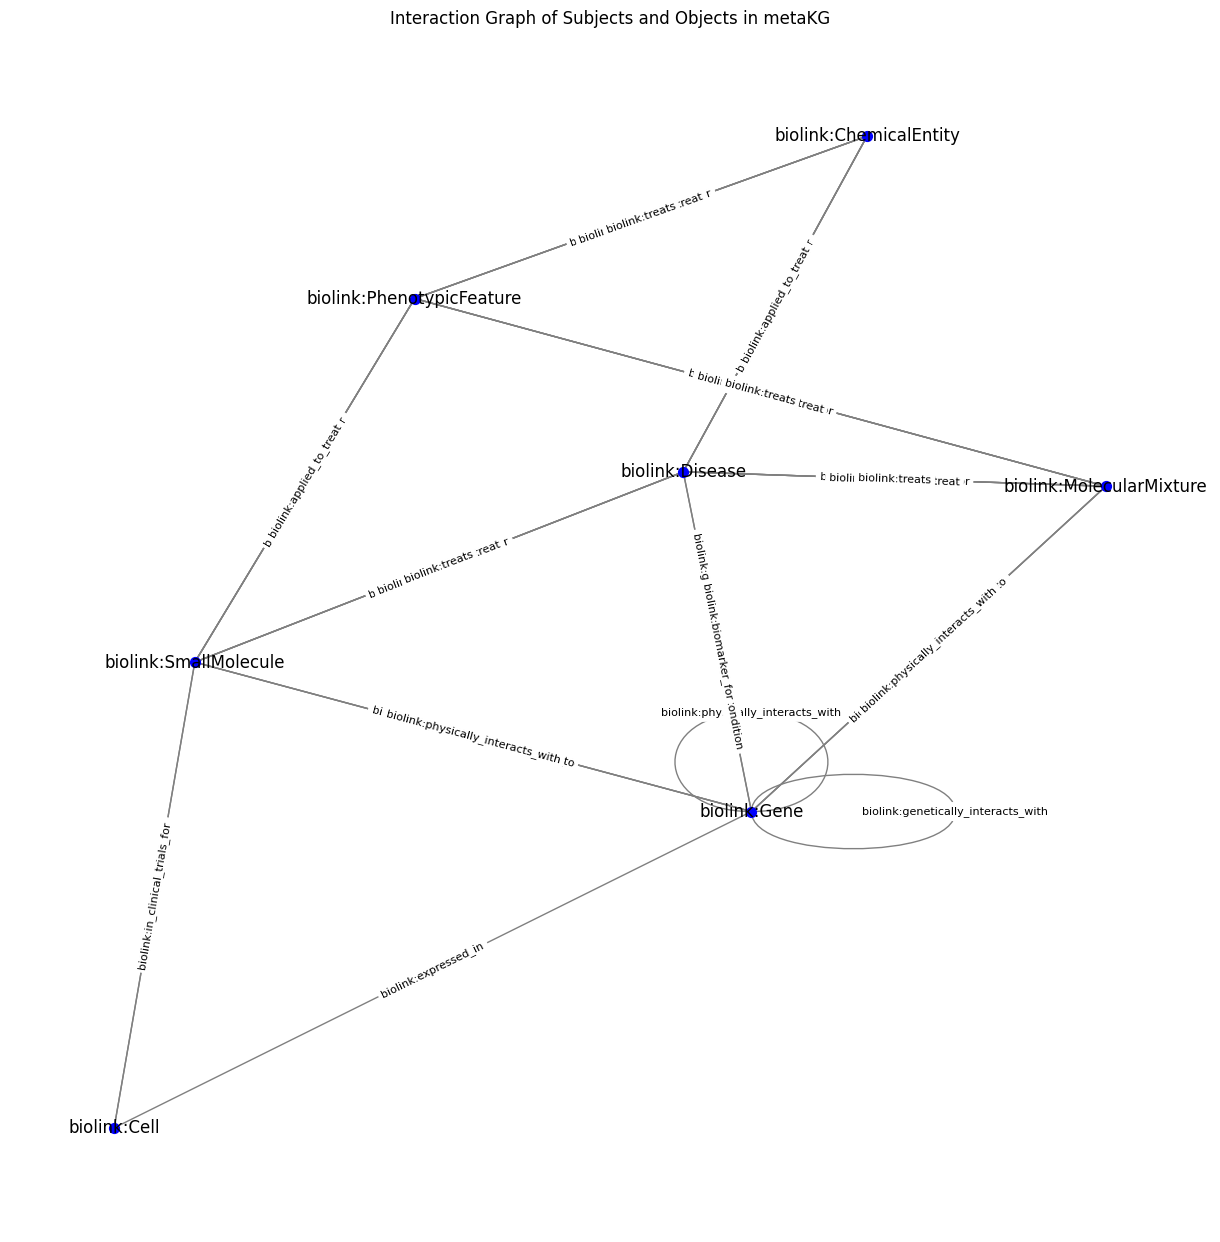

In [4]:
# draw the interaction graph between subject and object in the metaKG using networkx
# first, we need to drop the interactions between subjects and objects that both subjects and objects are the same
#metaKG = metaKG[metaKG['Subject'] != metaKG['Object']]
# second, we need to filter the metaKG to only include the selected categories
#metaKG = metaKG[metaKG['Subject'].isin(selected_categories) | metaKG['Object'].isin(selected_categories)]
selected_KGs = ['CATRAX BigGIM DrugResponse Performance Phase KP - TRAPI 1.5.0', 
                'Clinical Trials KP - TRAPI 1.5.0', 
                'Drug Approvals KP - TRAPI 1.5.0'
                ]

metaKG_sele = metaKG[metaKG['API'].isin(selected_KGs)]

# build a multigraph to capture all edges (including duplicates) and their predicates
G = nx.MultiGraph()
for _, row in metaKG_sele.iterrows():
        G.add_edge(row['Subject'], row['Object'], predicate=row['Predicate'])

# layout and draw nodes + edges
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw(G, pos,
                with_labels=True,
                node_size=50,
                font_size=12,
                font_color='black',
                node_color='blue',
                edge_color='gray')

# draw edge labels
edge_labels = nx.get_edge_attributes(G, 'predicate')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title('Interaction Graph of Subjects and Objects in metaKG')
plt.show()